In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gpflow

from utils import *
from plot import *

In [3]:
np.random.seed(1)

num_data = 200
dim = 5

xmin = -5
xmax = 5
break_pt = xmin + (xmax - xmin) * 0.6
k1 = 0.0
k21 = 0.5
k22 = -0.5
c1 = 0
sigma = 0.1
noise = 0.01

x = np.linspace(xmin, xmax, int(num_data/2), dtype=default_float())
X = branch_simulation(x, break_pt, k1, k21, k22, c1, sigma)
labels = np.repeat([0, 1], int(num_data)/2)
labels_dummy = pd.get_dummies(labels).values

In [6]:
fx, gx = bgp_kernel(X, break_pt, dim)

In [213]:
break_num = x[x < break_pt].size
halfpt = int(num_data / 2)
tmp1 = fx[:break_num]
tmp2 = fx[break_num:halfpt]
tmp3 = gx[-(halfpt-break_num):]
Y = np.concatenate([tmp1, tmp2, tmp1, tmp3], axis=0)

In [36]:
np.random.seed(3)
M = 30
X_pca = PCA(n_components=2).fit_transform(Y)
Z = np.random.permutation(X)[:M]

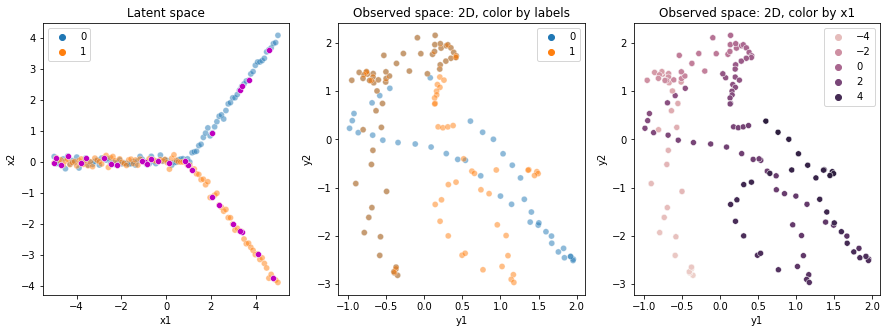

In [214]:
# without noise
plot_Y(Y, X, labels, Z)

Text(0, 0.5, 'y1')

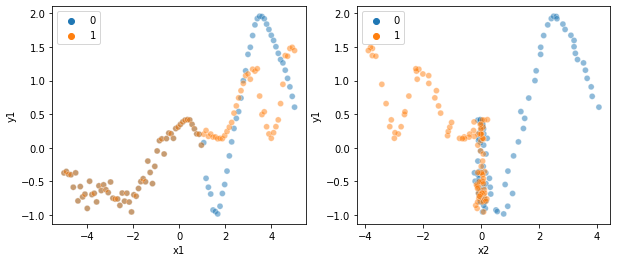

In [215]:
x1 = X[:, 0]
x2 = X[:, 1]
y1 = Y[:, 0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=x1, y=y1, hue=labels, alpha=0.5, ax=axs[0])
axs[0].set_xlabel('x1')
axs[0].set_ylabel('y1')
sns.scatterplot(x=x2, y=y1, hue=labels, alpha=0.5, ax=axs[1])
axs[1].set_xlabel('x2')
axs[1].set_ylabel('y1')

In [198]:
# add noise
#Y += np.random.normal(0, np.sqrt(noise), Y.shape)

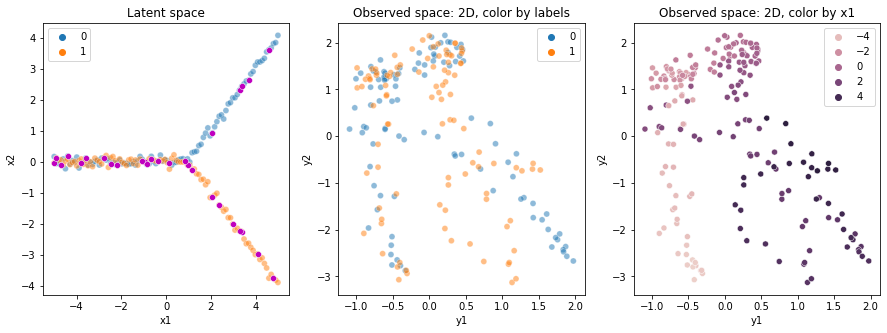

In [199]:
# with noise
plot_Y(Y, X, labels, Z)

Text(0, 0.5, 'y1')

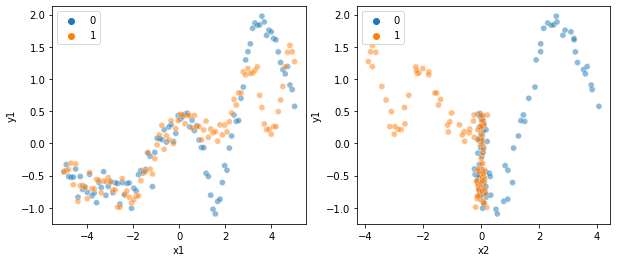

In [200]:
x1 = X[:, 0]
x2 = X[:, 1]
y1 = Y[:, 0]
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=x1, y=y1, hue=labels, alpha=0.5, ax=axs[0])
axs[0].set_xlabel('x1')
axs[0].set_ylabel('y1')
sns.scatterplot(x=x2, y=y1, hue=labels, alpha=0.5, ax=axs[1])
axs[1].set_xlabel('x2')
axs[1].set_ylabel('y1')

Text(0, 0.5, 'PC 2')

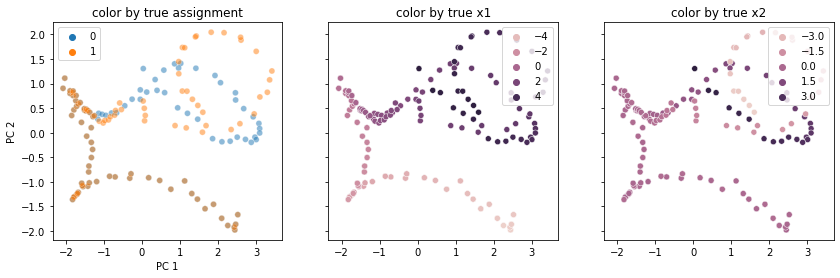

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
xmean = PCA(n_components=2).fit_transform(Y)
x1 = xmean[:, 0]
x2 = xmean[:, 1]
sns.scatterplot(x=x1, y=x2, hue=labels, ax=axs[0], alpha=0.5)
axs[0].set_title('color by true assignment')
sns.scatterplot(x=x1, y=x2, hue=X[:, 0], ax=axs[1])
axs[1].set_title('color by true x1')
sns.scatterplot(x=x1, y=x2, hue=X[:, 1], ax=axs[2])
axs[2].set_title('color by true x2')
axs[0].set_xlabel('PC 1')
axs[0].set_ylabel('PC 2')

In [93]:
def plot_embedding(m):
    fig, axs = plt.subplots(1, 4, figsize=(18, 4), sharex=True, sharey=True)
    x1 = m.Xs_mean.numpy().flatten()
    x2 = m.Xp_mean.numpy().flatten()
    sns.scatterplot(x=x1, y=x2, hue=labels, ax=axs[0], alpha=0.5)
    axs[0].set_title('color by true assignment')
    sns.scatterplot(x=x1, y=x2, hue=m.pi.numpy()[:, 0], ax=axs[1])
    axs[1].set_title('color by learned assignment')
    sns.scatterplot(x=x1, y=x2, hue=X[:, 0], ax=axs[2])
    axs[2].set_title('color by true x1')
    sns.scatterplot(x=x1, y=x2, hue=X[:, 1], ax=axs[3])
    axs[3].set_title('color by true x2')
    axs[0].set_xlabel('shared')
    axs[0].set_ylabel('private')

In [216]:
# fix X true
m1 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    K=2,
    Zp=Z[:, 1][:, np.newaxis],
    Qs=1,
    Zs=Z[:, 0][:, np.newaxis],
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float()),
    Xp_mean_init=X[:, 1][:, np.newaxis],
    Xp_var_init=np.full((num_data, 1), 1e-4),
    Xs_mean_init=X[:, 0][:, np.newaxis],
    Xs_var_init=np.full((num_data, 1), 1e-4)
)
m1.likelihood.variance.assign(0.01)
set_trainable(m1.Xp_mean, False)
set_trainable(m1.Xp_var, False)
set_trainable(m1.Xs_mean, False)
set_trainable(m1.Xs_var, False)

In [227]:
# learn X, init PC 1
m2 = init_split_gplvm(
    Y=Y,
    split_space=True,
    Qp=1,
    K=2,
    Zp=Z[:, 1][:, np.newaxis],
    Qs=1,
    Zs=Z[:, 0][:, np.newaxis],
    pi_init=tf.constant(np.random.dirichlet(alpha=[2, 2], size=(X.shape[0])), dtype=default_float())
)
m2.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [228]:
m = m2
set_trainable(m.likelihood.variance, False)
set_trainable(m.kernel_K[0].variance, False)
set_trainable(m.kernel_K[1].variance, False)
set_trainable(m.kernel_s.variance, False)
set_trainable(m.kernel_K[0].lengthscales, False)
set_trainable(m.kernel_K[1].lengthscales, False)
set_trainable(m.kernel_s.lengthscales, False)
set_trainable(m.Zp, False)
set_trainable(m.Zs, False)

In [219]:
%%time
elbo1 = train_natgrad_adam(m1, 2000, 10)

initial elbo -15019686.2814
iteration 10 elbo -2538.4142, took 0.1203s
iteration 20 elbo -2534.5413, took 0.0908s
iteration 30 elbo -2530.4046, took 0.0915s
iteration 40 elbo -2525.8859, took 0.1042s
iteration 50 elbo -2520.8721, took 0.0932s
iteration 60 elbo -2515.2905, took 0.0995s
iteration 70 elbo -2509.1165, took 0.0971s
iteration 80 elbo -2502.3645, took 0.1004s
iteration 90 elbo -2495.0783, took 0.0969s
iteration 100 elbo -2487.3268, took 0.0889s
iteration 110 elbo -2479.2063, took 0.0930s
iteration 120 elbo -2470.8433, took 0.0959s
iteration 130 elbo -2462.3852, took 0.1193s
iteration 140 elbo -2453.9829, took 0.1075s
iteration 150 elbo -2445.7726, took 0.1807s
iteration 160 elbo -2437.8641, took 0.0897s
iteration 170 elbo -2430.3342, took 0.0953s
iteration 180 elbo -2423.2273, took 0.1234s
iteration 190 elbo -2416.5595, took 0.0907s
iteration 200 elbo -2410.3251, took 0.0909s
iteration 210 elbo -2404.5044, took 0.1389s
iteration 220 elbo -2399.0702, took 0.1395s
iteration 230

iteration 1690 elbo -2276.6503, took 0.0887s
iteration 1700 elbo -2276.6260, took 0.1175s
iteration 1710 elbo -2276.6022, took 0.0911s
iteration 1720 elbo -2276.5789, took 0.0882s
iteration 1730 elbo -2276.5560, took 0.0877s
iteration 1740 elbo -2276.5335, took 0.0889s
iteration 1750 elbo -2276.5115, took 0.0907s
iteration 1760 elbo -2276.4898, took 0.0908s
iteration 1770 elbo -2276.4686, took 0.1164s
iteration 1780 elbo -2276.4477, took 0.0903s
iteration 1790 elbo -2276.4272, took 0.0867s
iteration 1800 elbo -2276.4071, took 0.0902s
iteration 1810 elbo -2276.3873, took 0.0858s
iteration 1820 elbo -2276.3679, took 0.0936s
iteration 1830 elbo -2276.3488, took 0.0940s
iteration 1840 elbo -2276.3301, took 0.0969s
iteration 1850 elbo -2276.3116, took 0.0904s
iteration 1860 elbo -2276.2935, took 0.0873s
iteration 1870 elbo -2276.2757, took 0.0892s
iteration 1880 elbo -2276.2582, took 0.0874s
iteration 1890 elbo -2276.2410, took 0.0913s
iteration 1900 elbo -2276.2241, took 0.0923s
iteration 

In [230]:
%%time
elbo2 = train_natgrad_adam(m2, 2000, 100)

initial elbo -127938558.4258
iteration 100 elbo -12730.1529, took 0.1377s
iteration 200 elbo -6761.5500, took 0.1394s
iteration 300 elbo -4398.5930, took 0.1710s
iteration 400 elbo -3114.2504, took 0.1382s
iteration 500 elbo -2435.5622, took 0.2256s
iteration 600 elbo -2074.6918, took 0.1348s
iteration 700 elbo -1835.4472, took 0.1563s
iteration 800 elbo -1637.8911, took 0.1346s
iteration 900 elbo -1479.0167, took 0.1381s
iteration 1000 elbo -1369.6774, took 0.1335s
iteration 1100 elbo -1288.1246, took 0.1370s
iteration 1200 elbo -1229.1004, took 0.1458s
iteration 1300 elbo -1184.6829, took 0.1344s
iteration 1400 elbo -1146.2079, took 0.1342s
iteration 1500 elbo -1114.3704, took 0.1465s
iteration 1600 elbo -1090.1858, took 0.1432s
iteration 1700 elbo -1070.7582, took 0.1504s
iteration 1800 elbo -1055.1779, took 0.1346s
iteration 1900 elbo -1042.8255, took 0.1445s
iteration 2000 elbo -1032.7333, took 0.1269s
CPU times: user 9min 57s, sys: 4min 24s, total: 14min 22s
Wall time: 5min 2s


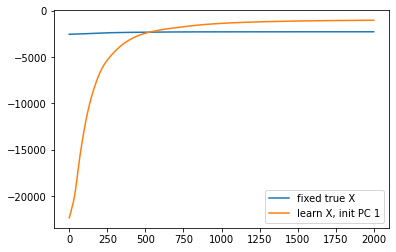

In [245]:
plt.plot(elbo1, label='fixed true X')
plt.plot(elbo2, label='learn X, init PC 1')
plt.legend()

In [248]:
m1

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.009999999999999998
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,False,(),float64,1.0
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,False,"(1,)",float64,[1.]
SplitGPLVM.kernel_K[1].variance,Parameter,Softplus,,False,(),float64,1.0
SplitGPLVM.kernel_K[1].lengthscales,Parameter,Softplus,,False,"(1,)",float64,[1.]
SplitGPLVM.Xp_mean,Parameter,,,False,"(200, 1)",float64,[[1.62434536e-01...
SplitGPLVM.Xp_var,Parameter,Softplus,,False,"(200, 1)",float64,[[1.e-04...
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 2)",float64,"[[5.60213044e-04, 9.99439787e-01..."
SplitGPLVM.Zp.Z,Parameter,,,False,"(30, 1)",float64,[[-0.01918356...
SplitGPLVM.q_mu[0],Parameter,,,False,"(30, 5)",float64,"[[-0.13787644, 1.86954173, 0.25374349..."


In [249]:
m2

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.009999999999999998
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,False,(),float64,1.0
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,False,"(1,)",float64,[1.]
SplitGPLVM.kernel_K[1].variance,Parameter,Softplus,,False,(),float64,1.0
SplitGPLVM.kernel_K[1].lengthscales,Parameter,Softplus,,False,"(1,)",float64,[1.]
SplitGPLVM.Xp_mean,Parameter,,,True,"(200, 1)",float64,[[1.01379021...
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(200, 1)",float64,[[0.0102026...
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(200, 2)",float64,"[[1.01861101e-03, 9.98981389e-01..."
SplitGPLVM.Zp.Z,Parameter,,,False,"(30, 1)",float64,[[-0.01918356...
SplitGPLVM.q_mu[0],Parameter,,,False,"(30, 5)",float64,"[[0.27133894, 1.76785801, 0.40603071..."


In [265]:
def plot_var_hist(m):
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs[0].hist(m.Xp_var.numpy())
    axs[0].set_title('Xp_var')
    triu_idx = np.triu_indices(m.M)
    axs[1].hist(m.q_sqrt[0].numpy()[0, triu_idx].flatten())
    axs[1].set_title('q_sqrt 0')
    axs[2].hist(m.q_sqrt[1].numpy()[0, triu_idx].flatten())
    axs[2].set_title('q_sqrt 1')
    if m.split_space:
        axs[3].hist(m.Xs_var.numpy())
        axs[3].set_title('Xs_var')

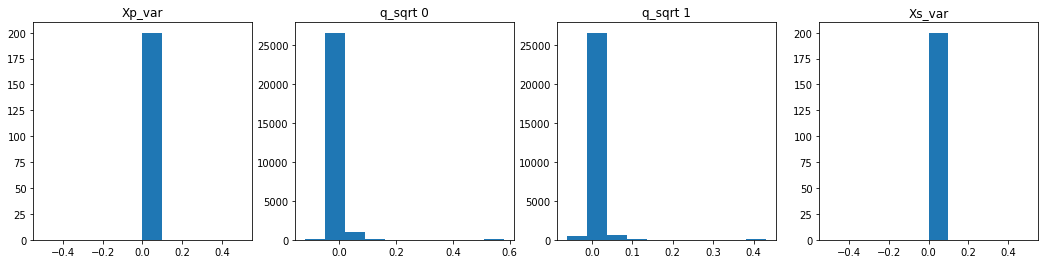

In [266]:
plot_var_hist(m1)

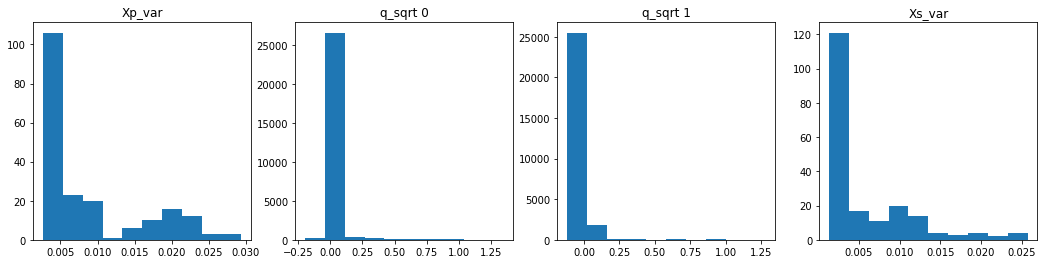

In [267]:
plot_var_hist(m2)

Text(0, 0.5, 'true x2')

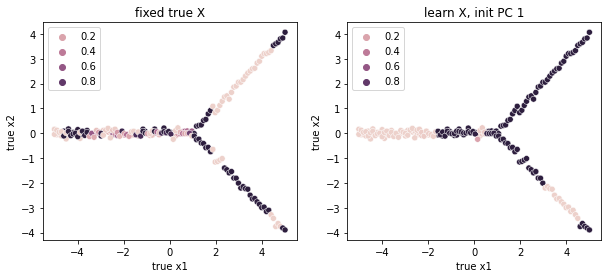

In [247]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_assignment(m1, X, axs[0])
axs[0].set_title('fixed true X')
axs[0].set_xlabel('true x1')
axs[0].set_ylabel('true x2')

plot_assignment(m2, X, axs[1])
axs[1].set_title('learn X, init PC 1')
axs[1].set_xlabel('true x1')
axs[1].set_ylabel('true x2')

Not sure why m1 gives such strong weight to some points on the trunk, when both functions predict equally well (as shown in the mixture plot), shouldn't it prefer uniform weight?

In [224]:
predm1, predKm1 = get_pred_Y(m1, by_K=True)

Text(0.5, 1.0, 'true observations by true labels')

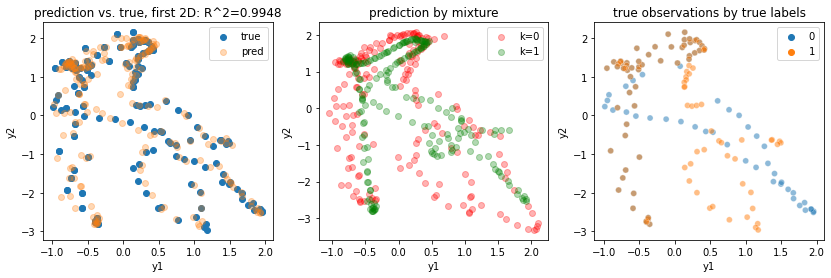

In [243]:
pred = predm1
predK = predKm1

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plot_pred_vs_true(Y, pred, axs[0])
plot_pred_by_K(predK, axs[1])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=labels, alpha=0.5, ax=axs[2])
axs[2].set_xlabel('y1')
axs[2].set_ylabel('y2')
axs[2].set_title('true observations by true labels')

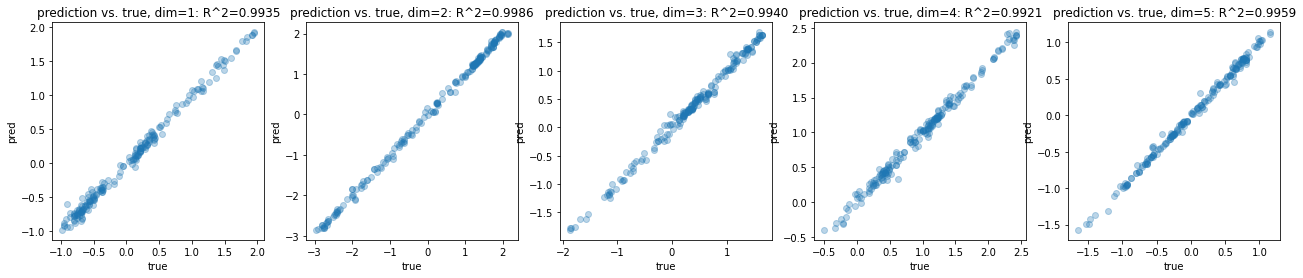

In [226]:
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
for i in range(dim):
    plot_pred_true_1d(Y, pred, i+1, axs[i])

the m2 embedding is kinda doing what I would expect, the shared space is used to model the trunk, private space describe the variation between the two branches (if you squint hard enough). But I'd expect the two branches to have shared space value around 0, and I'd expect the mixture weights on the trunk to be uniformly assigned. 

But if you look at the mixture prediction, it's actually using one mixture to predict the trunk (plus the orange, see the x2 vs. y1 plot, it's like one function is left plus middle, one function is right) and one to fit the blue. I currently don't have good way to visualize fs and fk separately (due to approximation, need some feedback)

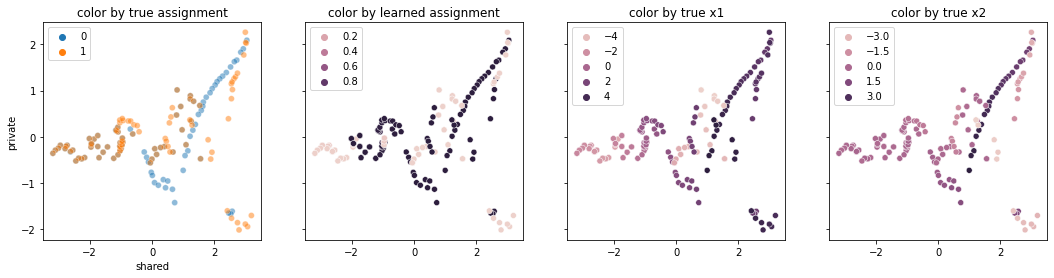

In [233]:
plot_embedding(m2)

In [234]:
predm2, predKm2 = get_pred_Y(m2, by_K=True)

Text(0, 0.5, 'y2')

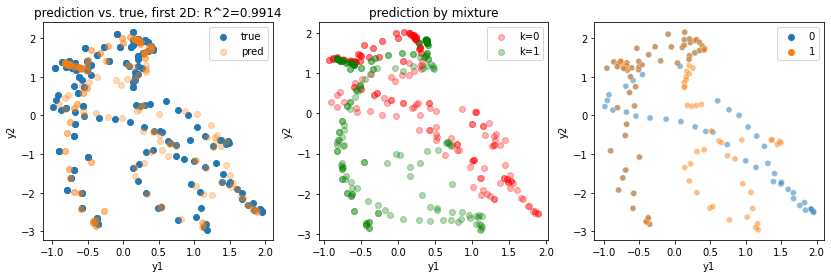

In [237]:
pred = predm2
predK = predKm2

fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plot_pred_vs_true(Y, pred, axs[0])
plot_pred_by_K(predK, axs[1])
sns.scatterplot(x=Y[:, 0], y=Y[:, 1], hue=labels, alpha=0.5, ax=axs[2])
axs[2].set_xlabel('y1')
axs[2].set_ylabel('y2')

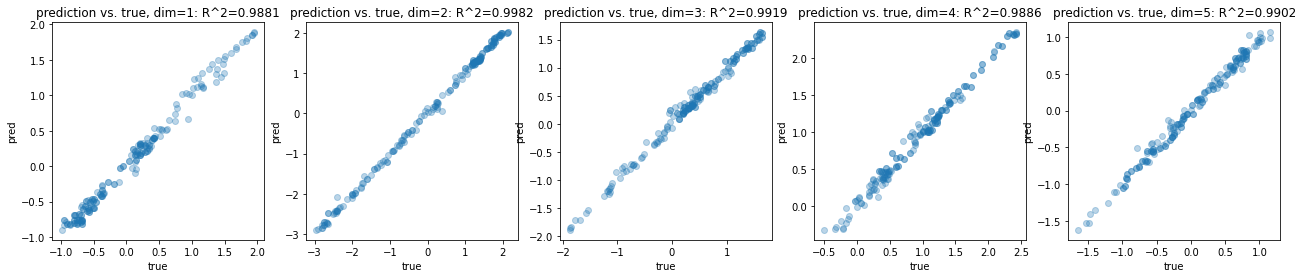

In [238]:
fig, axs = plt.subplots(1, 5, figsize=(22, 4))
for i in range(dim):
    plot_pred_true_1d(Y, pred, i+1, axs[i])

For comparison: GPLVM, PCA

In [239]:
gplvm = init_gplvm(
    Y=Y,
    latent_dim=2,
    kernel=gpflow.kernels.SquaredExponential(lengthscales=[1.0]*2),
    inducing_variable=Z
)
gplvm.likelihood.variance.assign(0.01)
set_trainable(gplvm.likelihood.variance, False)
set_trainable(gplvm.kernel.variance, False)
set_trainable(gplvm.kernel.lengthscales, False)
set_trainable(gplvm.inducing_variable, False)

In [240]:
gplvm

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,False,(),float64,1.0
BayesianGPLVM.kernel.lengthscales,Parameter,Softplus,,False,"(2,)",float64,[1. 1.]
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.009999999999999998
BayesianGPLVM.X_data_mean,Parameter,,,True,"(200, 2)",float64,"[[2.25963029, -1.88828842..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(200, 2)",float64,"[[1., 1...."
BayesianGPLVM.inducing_variable.Z,Parameter,,,False,"(30, 2)",float64,"[[-9.59595960e-01, -1.91835552e-02..."


In [241]:
elbo_gplvm = train_scipy(gplvm, 2000, True)

step 0 elbo: -32485.804526645206
step 1 elbo: -24847.51341391385
step 2 elbo: -17615.65276222487
step 3 elbo: -14043.419558722426
step 4 elbo: -12427.455458086582
step 5 elbo: -10288.650585769836
step 6 elbo: -8974.862671490951
step 7 elbo: -8551.641397599791
step 8 elbo: -7888.676157123872
step 9 elbo: -6937.810642272667
step 10 elbo: -6342.248147427121
step 11 elbo: -5952.837565713362
step 12 elbo: -5674.730390418626
step 13 elbo: -5383.081856774169
step 14 elbo: -5034.747118815647
step 15 elbo: -4693.164284819617
step 16 elbo: -4505.912142837778
step 17 elbo: -4334.567019453835
step 18 elbo: -4153.1067987104425
step 19 elbo: -4105.268943229715
step 20 elbo: -4026.9513975668033
step 21 elbo: -3911.0922244912126
step 22 elbo: -3804.0515659950083
step 23 elbo: -3759.7145230543474
step 24 elbo: -3693.3942801261755
step 25 elbo: -3593.51573387081
step 26 elbo: -3462.375692007167
step 27 elbo: -3384.7179175501497
step 28 elbo: -3327.4089911852698
step 29 elbo: -3276.180983693479
step 30 e

step 242 elbo: -1891.7627922390975
step 243 elbo: -1891.6586077089346
step 244 elbo: -1891.5111638604753
step 245 elbo: -1891.3058586982315
step 246 elbo: -1891.0836787365656
step 247 elbo: -1890.7546686474732
step 248 elbo: -1890.2247359574183
step 249 elbo: -1889.691575422567
step 250 elbo: -1889.022106410891
step 251 elbo: -1888.5834789925448
step 252 elbo: -1888.400319512184
step 253 elbo: -1888.2902262810487
step 254 elbo: -1888.1497780644245
step 255 elbo: -1888.0172746435735
step 256 elbo: -1887.8718636115736
step 257 elbo: -1887.6867153397113
step 258 elbo: -1887.3637546740524
step 259 elbo: -1886.8097609698043
step 260 elbo: -1886.3832094964964
step 261 elbo: -1886.3122769331642
step 262 elbo: -1886.1971023202736
step 263 elbo: -1886.05561224786
step 264 elbo: -1885.9683142652384
step 265 elbo: -1885.8214489027214
step 266 elbo: -1885.5562402131402
step 267 elbo: -1885.0844478334561
step 268 elbo: -1884.3809898217735
step 269 elbo: -1884.1664571175684
step 270 elbo: -1884.0595

Text(0, 0.5, 'latent dimension 2')

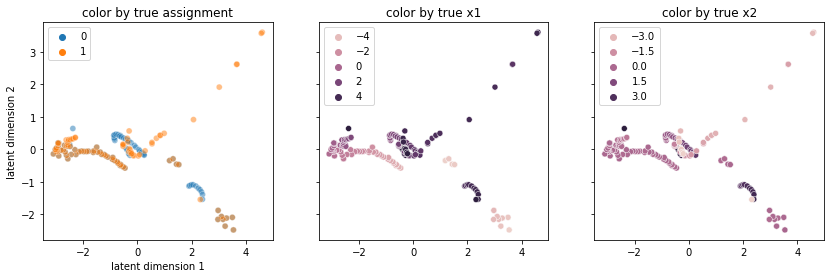

In [242]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
xmean = gplvm.X_data_mean.numpy()
x1 = xmean[:, 0]
x2 = xmean[:, 1]
sns.scatterplot(x=x1, y=x2, hue=labels, ax=axs[0], alpha=0.5)
axs[0].set_title('color by true assignment')
sns.scatterplot(x=x1, y=x2, hue=X[:, 0], ax=axs[1])
axs[1].set_title('color by true x1')
sns.scatterplot(x=x1, y=x2, hue=X[:, 1], ax=axs[2])
axs[2].set_title('color by true x2')
axs[0].set_xlabel('latent dimension 1')
axs[0].set_ylabel('latent dimension 2')